In [1]:
import sys
import os

# Add the parent directory of "tests" to sys.path
sys.path.append(os.path.abspath("/Users/workspace/Software/Layered_Tank_Simulation/CherenkovSim/"))

In [2]:
from cherenkov_sim.particle import Particle
from cherenkov_sim.muon import Muon
from cherenkov_sim.electron import Electron
from cherenkov_sim.gamma import Gamma
from cherenkov_sim.material import Material
from cherenkov_sim.tracker import ParticleTracker, GammaTracker
from cherenkov_sim.constants import ALPHA, R_TANK, H_TANK, TOP_TANK, ELECTRON_MASS, MUON_MASS


In [3]:
import ROOT
import numpy as np 
import matplotlib as mpl
from matplotlib import pyplot as plt
import astropy.units as u

In [4]:
ice = Material(
    name = 'Ice',
    Z_A = 0.55509 * u.mol / u.g,
    rho = 0.9180 * u.g / u.cm**3,
    I = 79.7 * u.eV, 
    n = 1.309,
    X0 = 39.31 * u.cm, 
    delta_file = '/Users/workspace/Software/PHYS-F-420/lesson2/delta_elec.txt'
)

water = Material(
    name = 'water',
    Z_A = 0.55509 * u.mol / u.g,
    rho = 1 * u.g / u.cm**3,
    I = 79.7 * u.eV,
    n = 1.333,
    X0 = 36.08 * u.cm, 
    delta_file = '/Users/workspace/Software/PHYS-F-420/lesson2/delta_elec.txt'
)

In [5]:
df = ROOT.RDataFrame("randomParticles", "/Users/workspace/Software/Layered_Tank_Simulation/CORSIKA_tree/allpart.root")

In [6]:
all_lept_filter = '(fSecondaryType==1 || fSecondaryType==2 || fSecondaryType==3 || fSecondaryType==5 || fSecondaryType==6)'


In [7]:
var = df.Filter(all_lept_filter).AsNumpy(['fSecondaryType','fPx','fPy','fPz'])

sec_type = var['fSecondaryType']
px = var['fPx']
py = var['fPy']
pz = var['fPz']

In [8]:
conditions = [
    (sec_type == 1),
    (np.isin(sec_type, [2,3]) ),
    (np.isin(sec_type, [5,6]) ),
]

labels = np.array(['Gamma' , 'Electron', 'Muon'], dtype=object)

type_string = np.select(conditions, labels, default="Unknown")

mass = np.select(conditions, [0 , ELECTRON_MASS.to(u.GeV), MUON_MASS.to(u.GeV)])

ptot = np.sqrt(px**2 + py**2 + pz**2) 
etot = np.sqrt(mass*mass + ptot*ptot)

theta = np.arccos(pz/ptot)
phi = np.arctan2(px,py)


In [9]:
# Gen. surface radius 
R_gen = 200 * u.cm 
Z_gen = 200 
 
def rnd_tank_start(R_gen, N_event): 
    r = R_gen * np.sqrt(np.random.uniform(0,1,size=N_event))
    alpha = np.random.uniform(0,2*np.pi, size=N_event) 
    z_value = Z_gen 
    x0 = r * np.cos(alpha)   
    y0 = r * np.sin(alpha)  
    z0 = np.full(N_event,z_value) * u.cm
    return x0, y0, z0  



In [10]:
# Extract secondary particles randomly and throw them on the tank 
# Randomly generate particle positions 

N_PARTICLES = 5000

N_tot = len(sec_type)
x0,y0,z0 = rnd_tank_start(R_gen, N_tot)  

N_particle = int(N_PARTICLES) # Choose number of particles to throw 
particle_id = np.random.randint(1, N_tot, size=N_particle)  # Generates N random int numbers

In [11]:
photons_mu_z = []
photons_mu_r = []

photons_e_z = []
photons_e_r = []

photons_gamma_z = []
photons_gamma_r = []

N_photons_mu = []
N_photons_e = []
N_photons_gamma = []

N_photons_top_mu = []
N_photons_top_e = []
N_photons_top_gamma = []

In [12]:
for part_id in particle_id:
    part_type = type_string[part_id]
    part_theta = theta[part_id] * u.rad 
    part_phi = phi[part_id] * u.rad
    part_etot = etot[part_id] * u.GeV

    print(part_type+' with energy ',part_etot)
    initial_position = np.array([x0[part_id].value,y0[part_id].value,z0[part_id].value]) * u.cm

    if(part_type == 'Muon'):
        muon = Muon(energy = part_etot)

        # Create the Tracker
        tracker = ParticleTracker(muon, water, step_size= - 1.0 * u.cm,
                        position=initial_position, 
                        zenith=part_theta, 
                        azimuth=part_phi)
    
        tracker.propagate(lambda1 = 300 * u.nm, lambda2 = 600 * u.nm)

        ph_z = np.asarray(tracker.cherenkov_photons_z)

        photons_mu_z.extend(tracker.cherenkov_photons_z)
        photons_mu_r.extend(tracker.cherenkov_photons_r)
        N_photons_mu.append(len(tracker.cherenkov_photons_z))

        top_mask = np.logical_and(ph_z > TOP_TANK.value, ph_z < H_TANK.value)
        N_photons_top_mu.append(len(ph_z[top_mask]))


    elif(part_type == 'Electron'):
        electron = Electron(energy = part_etot)
        electron.load_delta_parameter(water)

        # Create the Tracker
        tracker = ParticleTracker(electron, water, step_size= - 1.0 * u.cm,
                        position=initial_position, 
                        zenith=part_theta, 
                        azimuth=part_phi)
    
        tracker.propagate(lambda1 = 300 * u.nm, lambda2 = 600 * u.nm)

        ph_z = np.asarray(tracker.cherenkov_photons_z)

        photons_e_z.extend(tracker.cherenkov_photons_z)
        photons_e_r.extend(tracker.cherenkov_photons_r)
        N_photons_e.append(len(tracker.cherenkov_photons_z))

        top_mask = np.logical_and(ph_z > TOP_TANK.value, ph_z < H_TANK.value)
        N_photons_top_e.append(len(ph_z[top_mask]))


    elif(part_type == 'Gamma'):
        gamma = Gamma(energy = part_etot)

        tracker = GammaTracker(gamma, water, step_size= - 1.0 * u.cm,
                        position=initial_position, 
                        zenith=part_theta, 
                        azimuth=part_phi)
    
        pp_tracker = tracker.propagate()

        if(tracker.is_pair_production):
            electron_tracker = pp_tracker[0] 
            positron_tracker = pp_tracker[1]   

            electron_tracker.propagate(lambda1 = 300 * u.nm, lambda2 = 600 * u.nm)
            positron_tracker.propagate(lambda1 = 300 * u.nm, lambda2 = 600 * u.nm)

            ph_elec_z = np.asarray(electron_tracker.cherenkov_photons_z)
            ph_pos_z = np.asarray(positron_tracker.cherenkov_photons_z)

            photons_gamma_z.extend(electron_tracker.cherenkov_photons_z)
            photons_gamma_r.extend(electron_tracker.cherenkov_photons_r)
            photons_gamma_z.extend(positron_tracker.cherenkov_photons_z)
            photons_gamma_r.extend(positron_tracker.cherenkov_photons_r)
            N_photons_gamma.append(len(electron_tracker.cherenkov_photons_z))
            N_photons_gamma.append(len(positron_tracker.cherenkov_photons_z))

            top_mask_elec = np.logical_and(ph_elec_z > TOP_TANK.value, ph_elec_z < H_TANK.value)
            N_photons_top_gamma.append(len(ph_elec_z[top_mask_elec]))

            top_mask_pos = np.logical_and(ph_pos_z > TOP_TANK.value, ph_pos_z < H_TANK.value)
            N_photons_top_gamma.append(len(ph_pos_z[top_mask_pos]))



    else:
        print("Particle type not recognized!")

Gamma with energy  0.0016444678955653102 GeV
Muon with energy  2.6879550152655054 GeV
Gamma with energy  0.004114957324085877 GeV
Gamma with energy  0.05028145396856082 GeV
Gamma with energy  0.00606390564647604 GeV
Gamma with energy  0.01498407645130323 GeV
Gamma with energy  0.00064270468628598 GeV
Gamma with energy  0.3595652888302902 GeV
Gamma with energy  0.0028365501289446112 GeV
Gamma with energy  0.1487194341572412 GeV


/opt/anaconda3/envs/tank_env/lib/python3.12/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Gamma with energy  0.04515907193078706 GeV
Gamma with energy  0.015229270487118678 GeV
Muon with energy  1.0590098057945365 GeV
Gamma with energy  0.15205506397407487 GeV
Gamma with energy  0.004928140779333013 GeV
Gamma with energy  0.02167343838276244 GeV
Gamma with energy  0.025292185965827472 GeV
Gamma with energy  0.006065114585314938 GeV
Gamma with energy  0.035641562731071434 GeV
Gamma with energy  0.016840373524785044 GeV
Muon with energy  5.186403429188862 GeV
Gamma with energy  0.0009827515706472363 GeV
Muon with energy  2.6946257330727734 GeV
Gamma with energy  0.0207232102687007 GeV
Gamma with energy  0.017983856759911095 GeV
Muon with energy  2.5131958997712416 GeV
Gamma with energy  0.0005730211950792396 GeV
Gamma with energy  0.0010851409211254546 GeV
Muon with energy  3.0892463751936563 GeV
Gamma with energy  0.006754282843272482 GeV
Gamma with energy  0.02246555643884433 GeV
Gamma with energy  0.03288489764117261 GeV
Muon with energy  0.8119877710736918 GeV
Gamma with 

In [13]:
# Define range and bins of photon density histogram 

bin_width = 10
r_bins = np.arange(0,R_TANK.value+bin_width,bin_width)
z_bins = np.arange(0,H_TANK.value+bin_width,bin_width)

# Compute volume corresponding to each bin 
r_min, r_max = r_bins[:-1], r_bins[1:]
z_min, z_max = z_bins[:-1], z_bins[1:]

vol = np.zeros((len(r_min),len(z_min))) 
r_centers = (r_min+r_max) / 2.
z_centers = (z_min + z_max) / 2.

for i in range(len(r_min)): 
    for j in range(len(z_min)): 
        vol[i][j] = np.pi * (r_max[i]**2-r_min[i]**2)*(z_max[j]-z_min[j])
        
r_centers, z_centers = np.meshgrid(r_centers,z_centers)

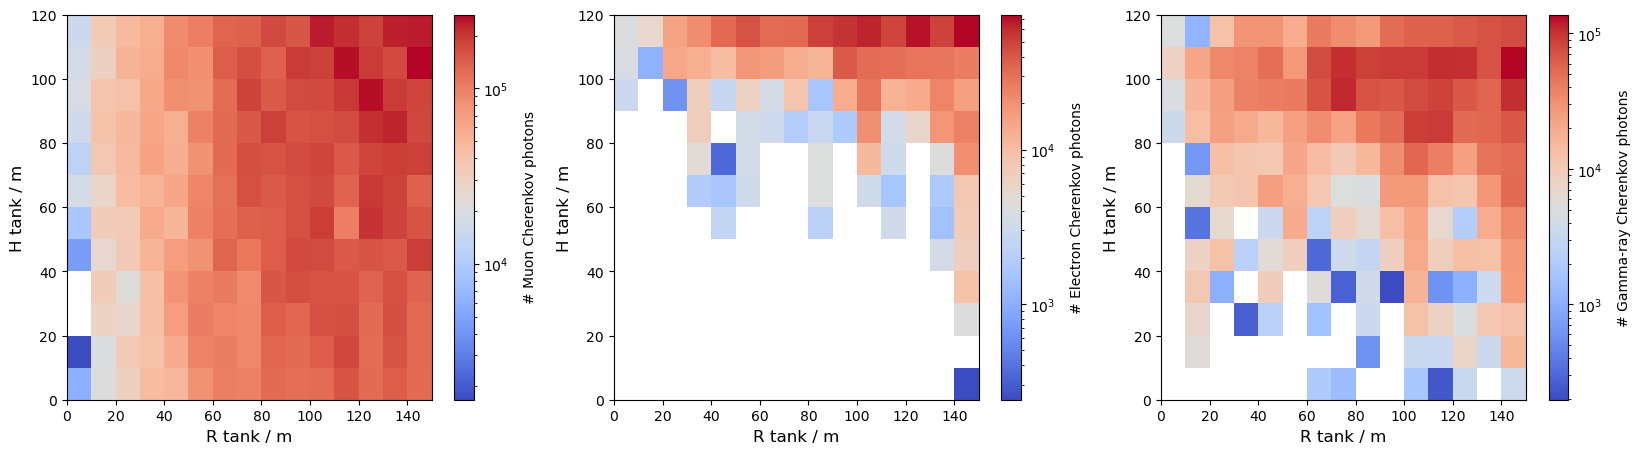

In [14]:
plt.subplots(1,3,figsize=(20,5))

plt.subplot(1,3,1)

hist_mu = plt.hist2d(photons_mu_r, photons_mu_z, bins=[r_bins,z_bins], norm=mpl.colors.LogNorm(), cmap = plt.cm.coolwarm )
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)
cbar = plt.colorbar()
cbar.set_label('# Muon Cherenkov photons', rotation=90, labelpad=10)

plt.subplot(1,3,2)

hist_elec = plt.hist2d(photons_e_r, photons_e_z, bins=[r_bins,z_bins], norm=mpl.colors.LogNorm(), cmap = plt.cm.coolwarm )
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)
cbar = plt.colorbar()
cbar.set_label('# Electron Cherenkov photons', rotation=90, labelpad=10)

plt.subplot(1,3,3)

hist_gamma = plt.hist2d(photons_gamma_r, photons_gamma_z, bins=[r_bins,z_bins], norm=mpl.colors.LogNorm(), cmap = plt.cm.coolwarm )
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)
cbar = plt.colorbar()
cbar.set_label('# Gamma-ray Cherenkov photons', rotation=90, labelpad=10)

(12, 15)
(12, 15)
(12, 15)
(12, 15)
(12, 15)
(12, 15)


Text(0, 0.5, 'H tank / m')

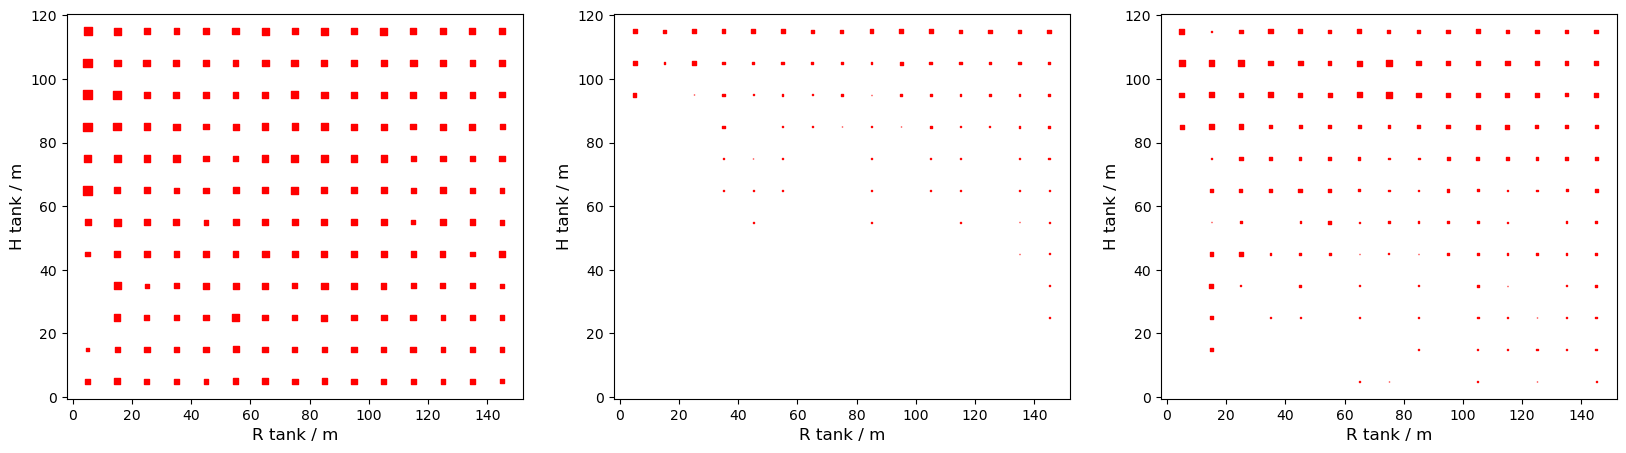

In [15]:
plt.subplots(1,3,figsize=(20,5))

plt.subplot(1,3,1)

bin_count_mu = hist_mu[0]
ph_density_mu = bin_count_mu / vol 

print(r_centers.shape)
print(z_centers.shape)

#plt.scatter(r_centers, z_centers, c = ph_density.T, marker='s')
#plt.colorbar()

plt.scatter(r_centers, z_centers, s=ph_density_mu.T*7, marker='s', c='red')
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)

plt.subplot(1,3,2)

bin_count_elec = hist_elec[0]
ph_density_elec = bin_count_elec / vol 

print(r_centers.shape)
print(z_centers.shape)

#plt.scatter(r_centers, z_centers, c = ph_density.T, marker='s')
#plt.colorbar()

plt.scatter(r_centers, z_centers, s=ph_density_elec.T*7, marker='s', c='red')
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)

plt.subplot(1,3,3)

bin_count_gamma = hist_gamma[0]
ph_density_gamma = bin_count_gamma / vol 

print(r_centers.shape)
print(z_centers.shape)

#plt.scatter(r_centers, z_centers, c = ph_density.T, marker='s')
#plt.colorbar()

plt.scatter(r_centers, z_centers, s=ph_density_gamma.T*7, marker='s', c='red')
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)

Text(0.5, 1.0, 'Top layer 40.0 cm')

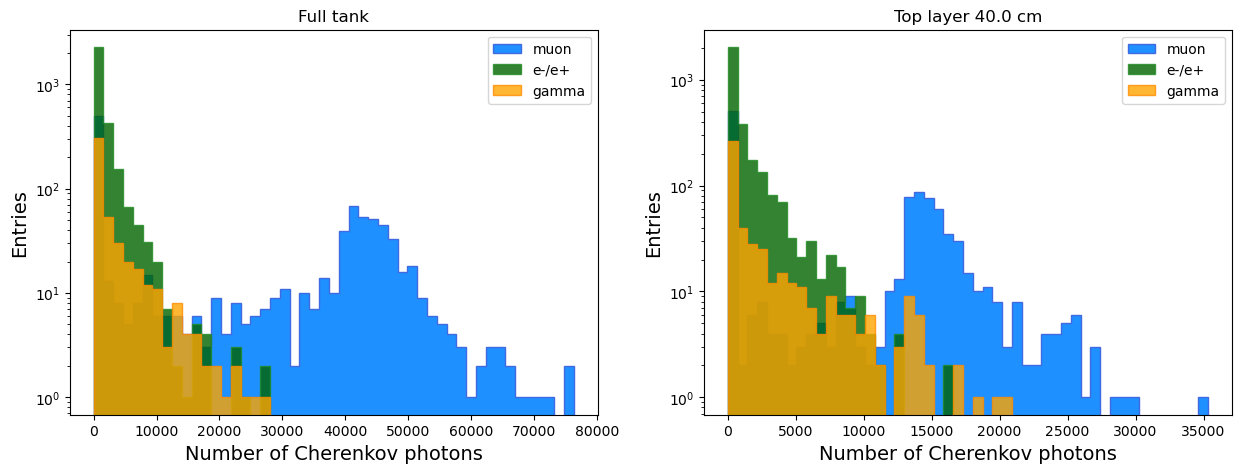

In [16]:
plt.subplots(1,2,figsize=(15,5))

plt.subplot(1,2,1)
max_photons = np.max(N_photons_mu) 
hist_bins = np.linspace(0,max_photons,50)

plt.hist(N_photons_mu, bins = hist_bins, color='dodgerblue',edgecolor='royalblue',histtype= "stepfilled", label = 'muon')
plt.hist(N_photons_gamma, bins = hist_bins, color='darkgreen',edgecolor='forestgreen',histtype= "stepfilled", alpha=0.8, label = 'e-/e+')
plt.hist(N_photons_e, bins = hist_bins, color='orange',edgecolor='darkorange',histtype= "stepfilled", alpha = 0.8, label = 'gamma')

plt.xlabel('Number of Cherenkov photons',size=14)
plt.ylabel('Entries',size=14)

plt.legend()
plt.yscale('log')

plt.title('Full tank')

plt.subplot(1,2,2)

max_photons_top = np.max(N_photons_top_mu) 
hist_top_bins = np.linspace(0,max_photons_top,50)

plt.hist(N_photons_top_mu, bins = hist_top_bins, color='dodgerblue',edgecolor='royalblue',histtype= "stepfilled", label = 'muon')
plt.hist(N_photons_top_gamma, bins = hist_top_bins, color='darkgreen',edgecolor='forestgreen',histtype= "stepfilled", alpha=0.8, label = 'e-/e+')
plt.hist(N_photons_top_e, bins = hist_top_bins, color='orange',edgecolor='darkorange',histtype= "stepfilled", alpha=0.8, label = 'gamma')

plt.xlabel('Number of Cherenkov photons',size=14)
plt.ylabel('Entries',size=14)

plt.legend()
plt.yscale('log')

plt.title('Top layer '+str(H_TANK-TOP_TANK))



Text(0.5, 1.0, 'Top layer 40.0 cm')

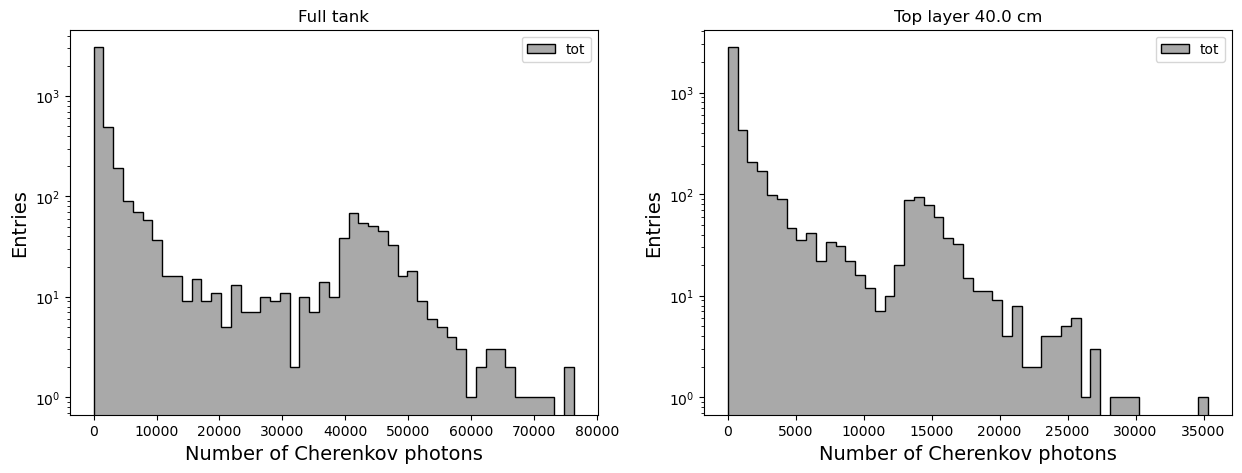

In [17]:
plt.subplots(1,2,figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(N_photons_mu + N_photons_e + N_photons_gamma, bins = hist_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label = 'tot')
plt.yscale('log')

plt.xlabel('Number of Cherenkov photons',size=14)
plt.ylabel('Entries',size=14)

plt.legend()
plt.yscale('log')

plt.title('Full tank')

plt.subplot(1,2,2)

plt.hist(N_photons_top_mu + N_photons_top_e + N_photons_top_gamma, bins = hist_top_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label = 'tot')
plt.yscale('log')

plt.xlabel('Number of Cherenkov photons',size=14)
plt.ylabel('Entries',size=14)

plt.legend()
plt.yscale('log')

plt.title('Top layer '+str(H_TANK-TOP_TANK))
